In [1]:
# -*- coding: utf-8 -*-

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

import tensorflow as tf
import numpy as np
import time

from genre_data_loader import movie_data
data = movie_data(data_type='image')

def initialize_session():
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    return tf.Session(config=config)

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train size 4800
y_train size 4800
x_test  size 1200
y_test  size 1200


In [2]:
##################################################
BATCH_SIZE = 128
class_size = 4
learning_rate = 0.001   # Learning rate
use_clip = True         # Gradient clipping 쓸지 여부
train_keep_prob = 0.7
train_total_batch = int(data.train_size / BATCH_SIZE)
test_total_batch = int(data.test_size / BATCH_SIZE)
train_acc_summary = [] # 학습용 데이터의 정확도를 중간 중간 기록한다
test_acc_summary = []  # 테스트용 데이터의 정확도를 중간 중간 기록한다
train_loss_summary = [] # 학습용 데이터의 정확도를 중간 중간 기록한다
test_loss_summary = []  # 테스트용 데이터의 정확도를 중간 중간 기록한다
hypothesis_summary = []
##################################################
from genre_model_resnet_style import Model
model = Model(use_clip=use_clip, class_size=class_size, learning_rate=learning_rate)

sess = initialize_session()
sess.run(tf.global_variables_initializer())

def test_model():
    test_loss, test_acc = 0, 0

    for _ in range(test_total_batch):
        test_x, test_y = data.get_test(BATCH_SIZE)
        
        loss, acc = sess.run([model.loss, model.accuracy],
                              feed_dict={model.x_image: test_x, model.y_label: test_y, model.keep_prob : 1.0, model.is_training:False})
        test_loss += loss
        test_acc += acc
        
    return test_loss/test_total_batch, test_acc/test_total_batch
    #print(" * test loss: {:.3f} | test acc: {:.3f}\n".format(test_loss / test_cnt, sess.run(model.accuracy, feed_dict={model.x_image: test_x, model.y_label: test_label})))



conv1 Tensor("MaxPool:0", shape=(?, 67, 45, 64), dtype=float32)
conv2 Tensor("dropout/mul:0", shape=(?, 33, 22, 128), dtype=float32)
conv3 Tensor("dropout_1/mul:0", shape=(?, 16, 11, 256), dtype=float32)
x_image Tensor("Mean:0", shape=(?, 256), dtype=float32)


In [3]:
for epoch in range(20):
    
    train_avg_loss, train_avg_acc = 0, 0
    
    for it in range(train_total_batch):
        train_x, train_y = data.get_train(BATCH_SIZE)
        
        loss, acc, _, hypothesis_ = sess.run([model.loss, model.accuracy, model.update, model.genre_prob], feed_dict={model.x_image: train_x, model.y_label: train_y, model.keep_prob:train_keep_prob, model.is_training:True})
        train_avg_loss += loss / train_total_batch
        train_avg_acc += acc / train_total_batch
        
        #if it % 10 == 0 and it > 0:
            #model.save(sess)
            #print("*Model Saved train_loss: {:.4f}, train_acc: {:.4f}".format(loss/BATCH_SIZE, acc))
        
    test_avg_loss, test_avg_acc = test_model()
    
    train_acc_summary.append(train_avg_acc)
    test_acc_summary.append(test_avg_acc)
    train_loss_summary.append(train_avg_loss)
    test_loss_summary.append(test_avg_loss)
    hypothesis_summary.append(hypothesis_)
    
    print("epoch {} - train_loss: {:.4f}, train_acc: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}"
          .format(epoch+1, train_avg_loss, train_avg_acc, test_avg_loss, test_avg_acc))  

epoch 1 - train_loss: 1.3096, train_acc: 0.3706, test_loss: 1.3000, test_acc: 0.3742
epoch 2 - train_loss: 1.2856, train_acc: 0.3985, test_loss: 1.2744, test_acc: 0.4125
epoch 3 - train_loss: 1.2729, train_acc: 0.4010, test_loss: 1.2708, test_acc: 0.3733
epoch 4 - train_loss: 1.2564, train_acc: 0.4215, test_loss: 1.2500, test_acc: 0.4225
epoch 5 - train_loss: 1.2371, train_acc: 0.4287, test_loss: 1.2387, test_acc: 0.4417
epoch 6 - train_loss: 1.2168, train_acc: 0.4573, test_loss: 1.2198, test_acc: 0.4450
epoch 7 - train_loss: 1.2025, train_acc: 0.4656, test_loss: 1.2074, test_acc: 0.4683
epoch 8 - train_loss: 1.1789, train_acc: 0.4821, test_loss: 1.1960, test_acc: 0.4608
epoch 9 - train_loss: 1.1641, train_acc: 0.4927, test_loss: 1.1759, test_acc: 0.4733
epoch 10 - train_loss: 1.1431, train_acc: 0.5056, test_loss: 1.1669, test_acc: 0.4800
epoch 11 - train_loss: 1.1246, train_acc: 0.5158, test_loss: 1.1541, test_acc: 0.4950
epoch 12 - train_loss: 1.1020, train_acc: 0.5340, test_loss: 1.

Max Train Accuracy 0.61%
Max Test Accuracy 0.51%


Text(0.5,0.98,'TEST')

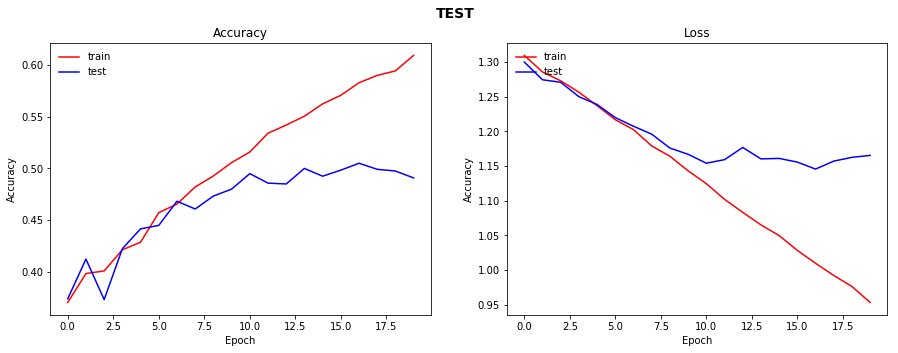

In [6]:
print('Max Train Accuracy {:.2f}%'.format(np.max(train_acc_summary)))
print('Max Test Accuracy {:.2f}%'.format(np.max(test_acc_summary)))

import matplotlib.pyplot as plt

# Get the figure and the axes
fig, (acc, loss) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(15, 5))

# 첫번째 그래프
acc.plot(train_acc_summary, 'r', label='train')
acc.plot(test_acc_summary, 'b', label='test')
acc.legend(loc='upper left', frameon=False)
acc.set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')

# 두번째 그래프
loss.plot(train_loss_summary, 'r', label='train')
loss.plot(test_loss_summary, 'b', label='test')
loss.legend(loc='upper left', frameon=False)
loss.set(title='Loss', xlabel='Epoch', ylabel='Accuracy')

# Title the figure
fig.suptitle('TEST', fontsize=14, fontweight='bold')

In [7]:
#model.restore(sess)

In [8]:
#test_avg_loss, test_avg_acc = test_model()
#test_avg_acc

In [9]:
hypothesis_summary[-1]

array([[3.3667773e-02, 5.6730127e-01, 1.3502705e-01, 2.6400390e-01],
       [5.0630420e-01, 1.7291715e-03, 4.3757707e-01, 5.4389562e-02],
       [5.5353588e-01, 1.2383614e-01, 1.2115230e-01, 2.0147564e-01],
       [2.9286247e-01, 4.0355507e-02, 5.7774864e-02, 6.0900724e-01],
       [2.7234644e-01, 2.7427709e-01, 1.4499238e-01, 3.0838409e-01],
       [7.7068515e-02, 5.7179458e-02, 5.9014028e-01, 2.7561179e-01],
       [6.0088265e-01, 1.9104604e-02, 2.0996752e-01, 1.7004529e-01],
       [7.6992369e-01, 3.4708604e-02, 7.2463907e-02, 1.2290387e-01],
       [8.5584480e-01, 8.6471923e-03, 6.6624872e-02, 6.8883099e-02],
       [6.1563253e-01, 8.3853476e-02, 1.8142650e-01, 1.1908756e-01],
       [1.8427598e-01, 6.1945081e-02, 1.6981272e-01, 5.8396620e-01],
       [2.1332709e-01, 4.6126366e-01, 2.4385862e-01, 8.1550643e-02],
       [1.0699044e-03, 3.6591440e-04, 9.5649278e-01, 4.2071413e-02],
       [5.3166315e-02, 1.7690097e-01, 3.8146436e-01, 3.8846835e-01],
       [1.3141927e-01, 1.4319406e-

In [10]:
w = hypothesis_summary[-1]
print(w.shape)
w = w.reshape(134,91,3,4)

w_min, w_max = np.min(w), np.max(w)

classes = ['Romance', 'Horror', 'Adventure', 'Documentary']
for i in range(4):
    plt.subplot(2,5,i+1)
    
    wimg=255.0*(w[:,:,:,i].squeeze() - w_min)/(w_max-w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

(16, 4)


ValueError: cannot reshape array of size 64 into shape (134,91,3,4)

In [ ]:
w = best_softmax.Weights[:-1, :]
w = w.reshape(32,32,3,10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2,5,i+1)
    
    wimg=255.0*(w[:,:,:,i].squeeze() - w_min)/(w_max-w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [ ]:
tt = tf.nn.softmax()